In [15]:
# imports
from tqdm import tnrange
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import numpy as np
import gc
import os
%matplotlib inline  

# alphabet
import string

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
def get_accuracy(logit, target):
    batch_size = len(target)
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

def nparam(ninputs,nhidden,noutputs):
    return ninputs*(nhidden+1) + nhidden*(nhidden+1)+nhidden*(noutputs+1)

# define the nnumber of parameters we need
def nparam_MLP(N_INPUTS,N_HIDDEN,N_OUTPUTS):
    input_to_hidden1 = (N_INPUTS+1)*N_HIDDEN #+1 for bias
    hidden1_to_hidden2 = (N_HIDDEN + 1)*N_HIDDEN
    hidden2_to_output = (N_OUTPUTS)*(N_HIDDEN+1)
    return(sum([input_to_hidden1,hidden1_to_hidden2,hidden2_to_output]))


In [3]:
# a prototype MLP
class MLP(nn.Module):
    def __init__(self, n_inputs, n_hidden_neurons, n_output,  device):
        super(MLP, self).__init__()
        self.n_inputs = n_inputs # set the number of neurons in the input layer
        self.n_hidden_neurons = n_hidden_neurons # how many neurons are in each hidden layer
        self.n_output = n_output # set the number of neurons in the output layer
        self.sig = nn.Sigmoid() # set the activation function 
        self.tanh = nn.Tanh()
        self.n_hidden = n_hidden_neurons
        self.encoder = nn.Linear(n_inputs, n_hidden_neurons) # encode input
        self.recurrent = nn.Linear(n_hidden_neurons,n_hidden_neurons) # recurrent connections
        self.decoder = nn.Linear(n_hidden_neurons, n_output) # decode output
                
    def forward(self, x):
        self.hidden1 = self.tanh(self.encoder(x))
        self.hidden2 = self.tanh(self.recurrent(self.hidden1))
        self.output = self.decoder(self.hidden2)
        return self.output
    

In [8]:
# Test MLP on Anna Karenina
# Load Anna Karenina
from torch.utils.data import DataLoader # dataloader 
import sys
sys.path.insert(0,'../final_project/Data/')
# from AnnaDataset_MLP import AnnaDataset, InvertAnna # import AK dataset
from AnnaDataset import AnnaDataset, InvertAnna # import AK dataset
import torchvision
import torchvision.transforms as transforms

# params
BATCH_SIZE = 500 # how many batches we are running
N_STEPS = 10 # How many characters are we inputting into the list at a time
N_HIDDEN_NEURONS = 512 # how many neurons per hidden layer
N_LAYERS = 2 # 2 hidden layers
N_EPOCHS = 11 # how many training epocs
learning_rates = np.asarray([2]) # learning rates
N_REPS = 1 # len(learning_rates) # the number of learning repetitions
N_PARAMS = nparam_MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS)
gidx = int(N_HIDDEN_NEURONS/2)

# regularization parameters
# lambdas = np.arange(0,1e-2,3e-3,dtype=np.float)
lambdas = np.arange(0,1,1e-1,dtype=np.float) # full sweep
N_LAMBDA = len(lambdas)

# load data
# list all transformations
transform = transforms.Compose(
    [transforms.Normalize((0,), (0.3,))])

dataset = AnnaDataset(N_STEPS) # load the dataset

N_INPUTS = len(dataset.categories)*N_STEPS
N_OUTPUTS = len(dataset.categories)

trainloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4) # create a DataLoader. We want a batch of BATCH_SIZE entries
testloader = DataLoader(dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=4) # create a DataLoader. We want a batch of BATCH_SIZE entries

Old length 1958224
New length 19582
['\n' ' ' '!' '"' "'" '(' ')' ',' '-' '.' '1' '2' '3' ':' ';' '?' 'A' 'B'
 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'L' 'M' 'N' 'O' 'P' 'R' 'S' 'T' 'W' 'Y' '_'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [9]:
print(trainloader)

In [12]:
# regularizing digonal blocks of the partitioned RNN
# initialize arrays of loss values and weights over the number of epohcs, the number of lambdas we are testing, and the number of reps. 
train_loss_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS)) 
train_acc_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
test_loss_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
test_acc_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
Phist_P = np.zeros((N_PARAMS,N_EPOCHS,N_LAMBDA,N_REPS))

model_P = [None]*N_LAMBDA*N_REPS # array of models
regval_P = [] # array of regularization values
for r in tnrange(N_REPS): # loop over the number of reps
    for k in tnrange(N_LAMBDA): # loop over the number of different lambda values
        reg_lambda = lambdas[k] # set the regularization lambda
        model_path = './model_P_rep_{}_lambda_{:d}_10.pt'.format(r,int(reg_lambda*10)) # path to which we will save the model
        model_P[k+r*N_LAMBDA] = MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS,device).to(device) # create the model
        l2_reg = torch.tensor(1,device=device) # create the l2 regularization value tensor
        optimizer = torch.optim.SGD(model_P[k+r*N_LAMBDA].parameters(), lr=1e-2, momentum=0.9) # set the function for SGD
        criterion = nn.CrossEntropyLoss() # set the loss function
        
        # note that cross-entropy loss expects the indices of the class, not the one-hot. So, for A = [1,0,0,...] and B = [0,1,0,...], A is 0 and B is 1
        
        for epoch in range(N_EPOCHS): # for each training epoch
            nps = 0
            running_train_loss=0
            running_train_acc=0
            model_P[k+r*N_LAMBDA].train() 
            for p, param in enumerate(model_P[k+r*N_LAMBDA].parameters()): # go through all the model parameters
                if param.requires_grad:
                    plist = torch.flatten(param.data) # set the list of parameters
                    for j in range(plist.size(0)):
                        while nps < Phist_P.shape[0]:
                            Phist_P[nps,epoch,k,r]=plist[j].item() # update the parameters
                            nps+=1

            for i, (x, y_tar) in enumerate(trainloader):
                l2_reg = 0
                x, y_tar = x.to(device), y_tar.to(device) # x is the training set, y_tar is the output label
                x = x-0.3
                optimizer.zero_grad() # set gradients to 0
                # print(x.shape)
                y_pred = model_P[k+r*N_LAMBDA](x.view(x.shape[0],x.shape[1]*x.shape[2])) # compute the prediction. # size mismatch
                
                
                loss = criterion(y_pred,y_tar) 
                for p,param in enumerate(model_P[k+r*N_LAMBDA].parameters()):
                    if param.requires_grad and len(param.shape)==2:
                        if param.shape[0]==N_HIDDEN_NEURONS and param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:gidx,:gidx].norm(p=1) # update the l2 regularization constant
                            l2_reg = l2_reg + param[gidx:,gidx:].norm(p=1)
                        elif param.shape[1]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:,gidx:].norm(p=1)
                        elif param.shape[0]==N_HIDDEN_NEURONS:
                            l2_reg = l2_reg + param[:gidx,:].norm(p=1)
                regval_P.append(l2_reg.item()) # add the l2 regularization to  the running list
                loss = loss + l2_reg*reg_lambda/BATCH_SIZE # compute the loss
                loss.backward() # backpropogate the loss
                optimizer.step() # run SGD
                running_train_loss+=loss.item()
                running_train_acc+=get_accuracy(y_pred, y_tar) # compute accuracy
            
            running_test_acc=0
            running_test_loss=0
            model_P[k+r*N_LAMBDA].eval()
            for i,(x_test, y_test_tar) in enumerate(testloader):
                x_test, y_test_tar = x_test.to(device), y_test_tar.to(device)
                x_test = x_test - 0.3
                y_test_pred = model_P[k+r*N_LAMBDA](x_test.view(x_test.shape[0],x_test.shape[1]*x_test.shape[2]))
                loss = criterion(y_test_pred,y_test_tar)
                
                running_test_loss+=loss.item()
                running_test_acc+=get_accuracy(y_test_pred, y_test_tar)
                
            train_loss_P[epoch,k,r] = running_train_loss/len(trainloader)
            train_acc_P[epoch,k,r] = running_train_acc/len(trainloader)
            test_loss_P[epoch,k,r] = running_test_loss/len(testloader)
            test_acc_P[epoch,k,r] = running_test_acc/len(testloader)
            print("Epoch %d; rep %d; lambda %f; train accuracy %f; train loss %f; test accuracy %f; test loss %f"
                  %(epoch,
                    r,
                    k,
                    train_acc_P[epoch,k,r],
                    train_loss_P[epoch,k,r],
                    test_acc_P[epoch,k,r],
                    test_loss_P[epoch,k,r]))
            
        # save the model and free the memory  
        torch.save(model_P[k+r*N_LAMBDA].state_dict(), model_path)
        model_P[k+r*N_LAMBDA] = [None]
        del(l2_reg,loss,optimizer,criterion,plist,param)

Epoch 0; rep 0; lambda 0.000000; train accuracy 15.200000; train loss 3.224476; test accuracy 20.375000; test loss 3.097584
Epoch 1; rep 0; lambda 0.000000; train accuracy 21.250000; train loss 2.906178; test accuracy 19.950000; test loss 3.064647
Epoch 2; rep 0; lambda 0.000000; train accuracy 22.700000; train loss 2.862826; test accuracy 28.575000; test loss 2.674932
Epoch 3; rep 0; lambda 0.000000; train accuracy 29.275000; train loss 2.541951; test accuracy 27.050000; test loss 2.660100
Epoch 4; rep 0; lambda 0.000000; train accuracy 30.000000; train loss 2.502305; test accuracy 32.000000; test loss 2.488427
Epoch 5; rep 0; lambda 0.000000; train accuracy 30.825000; train loss 2.464602; test accuracy 33.175000; test loss 2.444846
Epoch 6; rep 0; lambda 0.000000; train accuracy 32.650000; train loss 2.393784; test accuracy 33.725000; test loss 2.331541
Epoch 7; rep 0; lambda 0.000000; train accuracy 33.750000; train loss 2.338857; test accuracy 34.350000; test loss 2.332252
Epoch 8;

Epoch 1; rep 0; lambda 6.000000; train accuracy 17.375000; train loss 3.292695; test accuracy 5.975000; test loss 3.323328
Epoch 2; rep 0; lambda 6.000000; train accuracy 16.675000; train loss 3.142204; test accuracy 24.400000; test loss 3.012055
Epoch 3; rep 0; lambda 6.000000; train accuracy 23.125000; train loss 2.862460; test accuracy 23.825000; test loss 2.717747
Epoch 4; rep 0; lambda 6.000000; train accuracy 26.700000; train loss 2.680517; test accuracy 26.850000; test loss 2.729795
Epoch 5; rep 0; lambda 6.000000; train accuracy 28.550000; train loss 2.592909; test accuracy 31.300000; test loss 2.489814
Epoch 6; rep 0; lambda 6.000000; train accuracy 29.800000; train loss 2.535255; test accuracy 30.475000; test loss 2.529526
Epoch 7; rep 0; lambda 6.000000; train accuracy 30.750000; train loss 2.493377; test accuracy 32.975000; test loss 2.377097
Epoch 8; rep 0; lambda 6.000000; train accuracy 32.750000; train loss 2.421283; test accuracy 34.500000; test loss 2.378634
Epoch 9; 

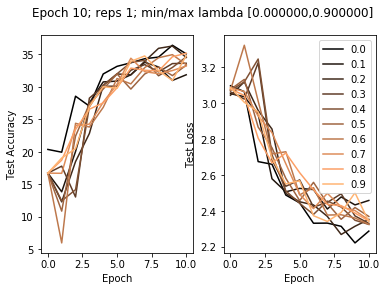

In [91]:

# number of lambdas
n_epochs_plot,n_lambdas_plot = np.mean(test_acc_P,2).shape

fig,ax = plt.subplots(1,2)
fig.subplots_adjust(hspace=20.0)

ax1,ax2 = ax
cm1 = plt.get_cmap('copper') # plt.get_cmap('gist_rainbow') # plt.get_cmap('gist_rainbow')
# fig = plt.figure()
NUM_COLORS = n_lambdas_plot
ax1.set_prop_cycle('color', [cm1(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])
ax2.set_prop_cycle('color', [cm1(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

fig.suptitle("Epoch %d; reps %d; min/max lambda [%f,%f]"
             %(epoch,
               N_REPS,
               min(lambdas),
               max(lambdas)))

# train accuracy %f; train loss %f; test accuracy %f; test loss %f"
# train_acc_P[epoch,k,r],
#                train_loss_P[epoch,k,r],
#                test_acc_P[epoch,k,r],
#                test_loss_P[epoch,k,r]
            
# ax = fig.add_subplot(111)
for i in enumerate(lambdas):
    ax1.plot(np.mean(test_acc_P,2)[:,i[0]],label=i[1],)
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Test Accuracy")
    
# ax2 = fig.add_subplot(011)
for i in enumerate(lambdas):
    ax2.plot(np.mean(test_loss_P,2)[:,i[0]],label=i[1],)
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Test Loss")
ax2.legend(loc="upper right")






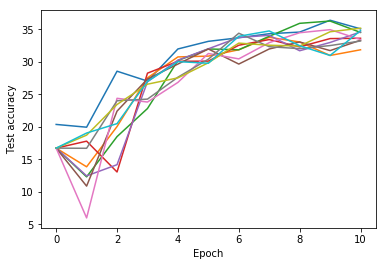

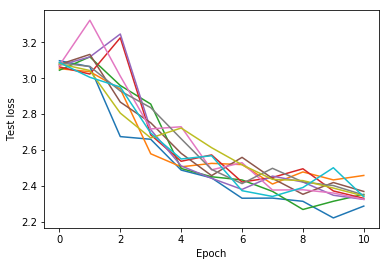

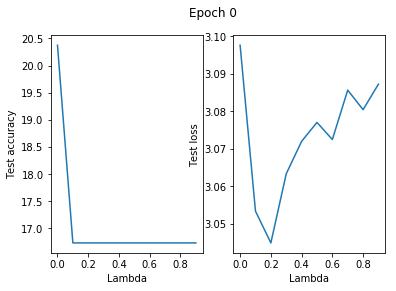

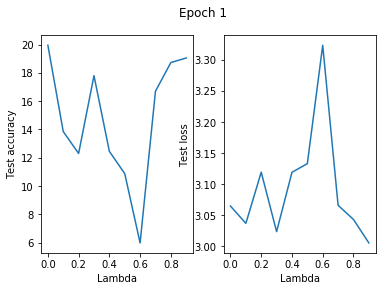

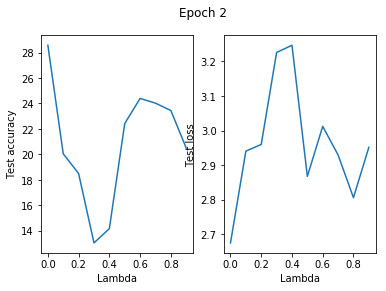

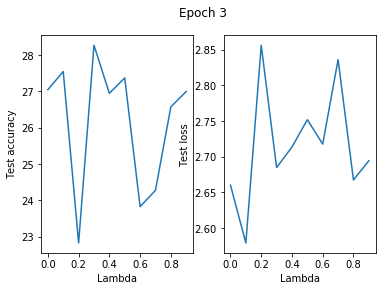

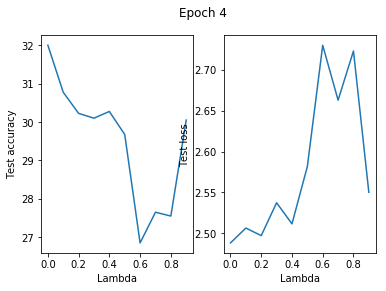

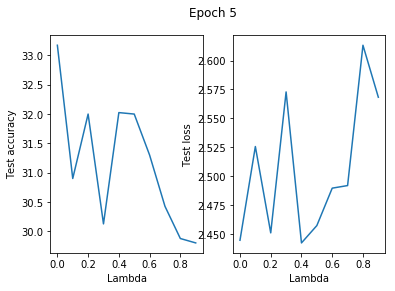

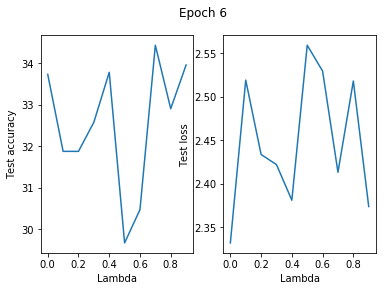

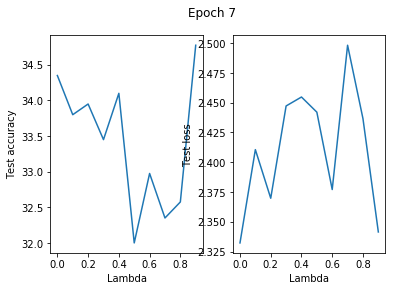

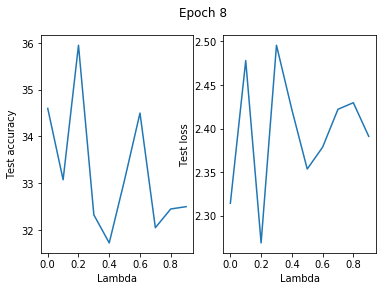

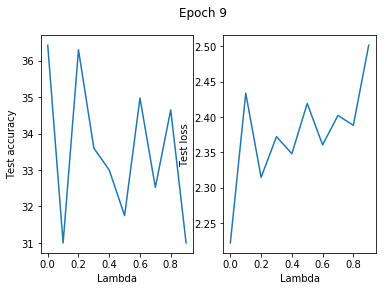

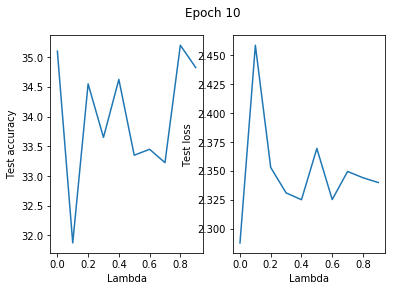

In [13]:
# # create colormap



# #plt.imshow(x[0,:,:])
# #plt.plot(y_pred.detach().numpy()[0,:])
# #torch.max(y_pred,1)
# plt.figure(1)
# plt.plot(np.mean(test_acc_P,2))
# plt.xlabel("Epoch")
# plt.ylabel("Test accuracy")
# plt.plot()

# plt.figure(2)
# plt.plot(np.mean(test_loss_P,2))
# plt.xlabel("Epoch")
# plt.ylabel("Test loss")
# plt.plot()


# for i,j in enumerate(zip(np.mean(test_acc_P,2),np.mean(test_loss_P,2))):
#     # plt.figure(i+3) # Here's the part I need, but numbering starts at 1!
#     fig,axs = plt.subplots(1,2)
#     fig.suptitle("Epoch %d; reps %d; lambda %f; train accuracy %f; train loss %f; test accuracy %f; test loss %f"
#                   %(epoch,
#                     REPS,
#                     k,
#                     train_acc_P[epoch,k,r],
#                     train_loss_P[epoch,k,r],
#                     test_acc_P[epoch,k,r],
#                     test_loss_P[epoch,k,r]))
#     axs[0].plot(lambdas,j[0])
#     axs[0].set_xlabel("Lambda")
#     axs[0].set_ylabel("Test accuracy")
#     # axs[0].title("Epoch %d"%i)
#     axs[1].plot(lambdas,j[1])
#     axs[1].set_xlabel("Lambda")
#     axs[1].set_ylabel("Test loss")
#     # axs[1].title("Epoch %d"%i)


# # plt.plot(np.mean(test_acc_P,1))
# # plt.plot()

# # plt.plot(np.mean(test_acc_P,2))
# # plt.plot()

# # plt.plot(np.mean(test_acc_P,3))
# # plt.plot()

In [ ]:
def readtxt(txt_name = 'anna.txt'):
    dir_path = os.path.dirname(os.path.realpath(__file__))
    txt_file = os.path.join(dir_path,txt_name)
    # load the whole book
    file = open(self.txt_file)
    alltxt = file.read()
    # remove newline formmating
    alltxt = alltxt.replace("\n\n", "&").replace("\n", " ").replace("&", "\n")
    # define categories
    categories = list(sorted(set(alltxt)))
    # integer encode
    label_encoder = LabelEncoder()
    label_encoder.fit(categories)
    integer_encoded = torch.LongTensor(label_encoder.transform(list(alltxt)))
    return integer_encoded, categories

# def onehotencode(integer_encoded_batch,n_cat):
    
# def get_next_batch(dat,batch_size):
#     x_int = 
#     y_int = 
#     x_hot = onehotencode(x_int): 
#     return x_hot, y_int 
    
    

In [ ]:
import pickle

# BATCH_SIZE = 500 # how many batches we are running
# N_STEPS = 10 # How many characters are we inputting into the list at a time
# N_HIDDEN_NEURONS = 512 # how many neurons per hidden layer
# N_INPUTS = 77*N_STEPS
# N_OUTPUTS = 77
# N_LAYERS = 2 # 2 hidden layers
# N_EPOCHS = 11 # how many training epocs
# learning_rates = np.asarray([2]) # learning rates
# N_REPS = 3 # len(learning_rates) # the number of learning repetitions
# N_PARAMS = nparam_MLP(N_INPUTS,N_HIDDEN_NEURONS,N_OUTPUTS)
# gidx = int(N_HIDDEN_NEURONS/2)


# train_loss_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS)) 
# train_acc_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
# test_loss_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
# test_acc_P = np.zeros((N_EPOCHS,N_LAMBDA,N_REPS))
# Phist_P = np.zeros((N_PARAMS,N_EPOCHS,N_LAMBDA,N_REPS))

# model_P = [None]*N_LAMBDA*N_REPS # array of models
# regval_P = [] # array of regularization values



pickle.dump([lambdas,N_EPOCHS,N_REPS,N_HIDDEN_NEURONS,learning_rates,N_REPS,N_PARAMS,
             model_P,
             train_loss_P,train_acc_P,
             test_loss_P,test_acc_P,
             Phist_P], 
            open( "mlp_ak_set.pkl", "wb" ) )

In [ ]:
# print(test_acc_P.shape)
# plt.plot(np.mean(test_acc_P,2))
# plt.plot()
# print(np.mean(test_acc_P,1))
# print(np.mean(test_acc_P,1).shape)